In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [3]:
class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias


class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)



In [4]:
class Net(nn.Module):
  #BN_flag 0: normal batchnorm; 1: Ghost batchnorm
    def batch_norm(self,channels, BN_flag):
          if BN_flag == 1:
            return GhostBatchNorm(channels, num_splits=2, weight=False)
          else:
            return nn.BatchNorm2d(channels)

    def __init__(self,BN_flag):
        super(Net, self).__init__() 

        self.conv1 = nn.Conv2d(1, 8, 3) #input -? OUtput? RF #28,26,3 
        self.batchnorm1 = self.batch_norm(8, BN_flag)
        #self.dp1 = nn.Dropout(0.20)

        self.conv2 = nn.Conv2d(8, 20, 3)#26,24,5
        self.batchnorm2 = self.batch_norm(20, BN_flag)

        self.dp2 = nn.Dropout(0.10)

        self.pool1 = nn.MaxPool2d(2, 2)#24,12,10

        self.conv3 = nn.Conv2d(20, 10, 1)#12,12,10
        self.batchnorm3 = self.batch_norm(10, BN_flag)
        self.dp3 = nn.Dropout(0.10)

        self.conv4 = nn.Conv2d(10, 14, 3)#12,10,12
        self.batchnorm4 = self.batch_norm(14, BN_flag)
        self.dp4 = nn.Dropout(0.10)

        #self.pool2 = nn.MaxPool2d(2, 2)#10,5,24
        
        self.conv5 = nn.Conv2d(14, 18, 3)#10,8,12
        self.batchnorm5 = self.batch_norm(18, BN_flag)
        self.dp5 = nn.Dropout(0.10)

        self.conv6 = nn.Conv2d(18, 24, 3)#8,6,14
        self.batchnorm6 = self.batch_norm(24, BN_flag)
        self.dp6 = nn.Dropout(0.10)

    
        self.conv7_avgp = nn.AvgPool2d(kernel_size=6)
        self.conv8 = nn.Conv2d(24, 10, 1)#6,4,18

    def forward(self, x):
      x = self.conv1(x)
      x = F.relu(x)
      x = self.batchnorm1(x)

      x = self.conv2(x)
      x = F.relu(x)
      x = self.batchnorm2(x)
      x = self.dp2(x)

      x = self.pool1(x)

      x = self.conv3(x)
      x = F.relu(x)
      x = self.batchnorm3(x)
      x = self.dp3(x)

      x = self.conv4(x)
      x = F.relu(x)
      x = self.batchnorm4(x)
      x = self.dp4(x)

      x = self.conv5(x)
      x = F.relu(x)
      x = self.batchnorm5(x)
      x = self.dp5(x)

      x = self.conv6(x)
      x = F.relu(x)
      x = self.batchnorm6(x)
      x = self.dp6(x)
  
      x = self.conv7_avgp(x)
      x = self.conv8(x) 
        
      x = x.view(-1, 10)
      return F.log_softmax(x)

In [5]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model_ = Net(0).to(device)
summary(model_, input_size=(1, 28, 28))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
       BatchNorm2d-2            [-1, 8, 26, 26]              16
            Conv2d-3           [-1, 20, 24, 24]           1,460
       BatchNorm2d-4           [-1, 20, 24, 24]              40
           Dropout-5           [-1, 20, 24, 24]               0
         MaxPool2d-6           [-1, 20, 12, 12]               0
            Conv2d-7           [-1, 10, 12, 12]             210
       BatchNorm2d-8           [-1, 10, 12, 12]              20
           Dropout-9           [-1, 10, 12, 12]               0
           Conv2d-10           [-1, 14, 10, 10]           1,274
      BatchNorm2d-11           [-1, 14, 10, 10]              28
          Dropout-12           [-1, 14, 10, 10]               0
           Conv2d-13             [-1, 18, 8, 8]           2,286
      BatchNorm2d-14             [-1, 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:81: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [6]:
torch.manual_seed(1)
batch_size = 128

In [7]:
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.RandomRotation((-8.0, 8.0), fill=(1,)),                       
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!





/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [8]:
from tqdm import tqdm
test_loss_ = []
train_loss = 0

def train(model, device, train_loader, optimizer, epoch, l1_regularization = [1,0.001]):
    model.train()
    train_correct = 0
    train_loss = 0
    type = l1_regularization[0]
    l = l1_regularization[1]
    pbar = tqdm(train_loader,leave=False,position=0)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        output = model(data)
        optimizer.zero_grad()
        
        if type == 1:
          l1_regularization = 0
          for param in model.parameters():
            l1_regularization += torch.sum(abs(param))
          train_loss = F.nll_loss(output, target) + l * l1_regularization
        else:
          train_loss = F.nll_loss(output, target)
              
        train_loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        train_correct += pred.eq(target.view_as(pred)).sum().item()
        pbar.set_description(desc= f'loss={train_loss.item()} batch_id={batch_idx}')
        
    print('Epoch: {:.0f},LR: {}.\nTrain set: train Average loss: {:.4f}, train_Accuracy: {}/{} ({:.4f}%)\n'.format(
        epoch,optimizer.param_groups[0]['lr'],train_loss, train_correct, len(train_loader.dataset),
        100. * train_correct / len(train_loader.dataset)))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return 100. * correct / len(test_loader.dataset), test_loss

In [9]:
from torch.optim.lr_scheduler import StepLR

In [10]:
accu = []
loss_test = []


for idx in range(0,5):
  #L1 regularization with Batch Normalization
  if idx == 0:
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    model_ = Net(BN_flag = 0).to(device)
    l1_regularization = [1,0.001]
    optimizer = optim.SGD(model_.parameters(), lr=0.016, momentum=0.9)
    scheduler = StepLR(optimizer, step_size=2, gamma=0.92)
     
  #L2 regularization with Batch Normalization 
  if idx == 1:     
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    model_ = Net(BN_flag = 0).to(device)   
    l1_regularization = [0,0]
    optimizer = optim.SGD(model_.parameters(), lr=0.016, momentum=0.9, weight_decay=0.001)

  #L1 and L2 with Batch Normalization
  if idx == 2:
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    model_ = Net(BN_flag = 0).to(device)
    l1_regularization = [1,0.001]
    optimizer = optim.SGD(model_.parameters(), lr=0.016, momentum=0.9, weight_decay=0.001)

  #with GBN
  if idx == 3:
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    model_ = Net(BN_flag = 1).to(device)  
    optimizer = optim.SGD(model_.parameters(), lr=0.016, momentum=0.9)
    scheduler = StepLR(optimizer, step_size=2, gamma=0.92)

  #with L1 and L2 with GBN
  if idx == 4:
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    model_ = Net(BN_flag = 1).to(device) 
    l1_regularization = [1,0.001]  
    optimizer = optim.SGD(model_.parameters(), lr=0.016, momentum=0.9, weight_decay=0.001)
    scheduler = StepLR(optimizer, step_size=2, gamma=0.92)
    

  valid_acc = []
  loss_test_ = []

  for epoch in range(1, 26):
    train(model_, device, train_loader, optimizer, epoch, l1_regularization)
    scheduler.step()
    valid_a, valid_l = test(model_, device, test_loader)
    #Appending to loss and accuracy lists
    valid_acc.append(valid_a)
    loss_test_.append(valid_l)
  
  accu.append(valid_acc)
  loss_test.append(loss_test_)

  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:81: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
                                                                                       

Epoch: 1,LR: 0.016.
Train set: train Average loss: 0.4492, train_Accuracy: 53128/60000 (88.5467%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1381, Accuracy: 9640/10000 (96.4000%)



Epoch: 2,LR: 0.016.
Train set: train Average loss: 0.4142, train_Accuracy: 57916/60000 (96.5267%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0918, Accuracy: 9770/10000 (97.7000%)



Epoch: 3,LR: 0.01472.
Train set: train Average loss: 0.4615, train_Accuracy: 58209/60000 (97.0150%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0795, Accuracy: 9758/10000 (97.5800%)



Epoch: 4,LR: 0.01472.
Train set: train Average loss: 0.4511, train_Accuracy: 58241/60000 (97.0683%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0890, Accuracy: 9730/10000 (97.3000%)



Epoch: 5,LR: 0.013542400000000001.
Train set: train Average loss: 0.3469, train_Accuracy: 58293/60000 (97.1550%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0688, Accuracy: 9802/10000 (98.0200%)



Epoch: 6,LR: 0.013542400000000001.
Train set: train Average loss: 0.4188, train_Accuracy: 58356/60000 (97.2600%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0701, Accuracy: 9798/10000 (97.9800%)



Epoch: 7,LR: 0.012459008000000002.
Train set: train Average loss: 0.3916, train_Accuracy: 58411/60000 (97.3517%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0755, Accuracy: 9757/10000 (97.5700%)



Epoch: 8,LR: 0.012459008000000002.
Train set: train Average loss: 0.2962, train_Accuracy: 58354/60000 (97.2567%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1122, Accuracy: 9653/10000 (96.5300%)



Epoch: 9,LR: 0.011462287360000002.
Train set: train Average loss: 0.3724, train_Accuracy: 58464/60000 (97.4400%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1255, Accuracy: 9612/10000 (96.1200%)



Epoch: 10,LR: 0.011462287360000002.
Train set: train Average loss: 0.3046, train_Accuracy: 58395/60000 (97.3250%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0529, Accuracy: 9846/10000 (98.4600%)



Epoch: 11,LR: 0.010545304371200001.
Train set: train Average loss: 0.3828, train_Accuracy: 58504/60000 (97.5067%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1052, Accuracy: 9674/10000 (96.7400%)



Epoch: 12,LR: 0.010545304371200001.
Train set: train Average loss: 0.3119, train_Accuracy: 58437/60000 (97.3950%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0882, Accuracy: 9724/10000 (97.2400%)



Epoch: 13,LR: 0.009701680021504002.
Train set: train Average loss: 0.3253, train_Accuracy: 58477/60000 (97.4617%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0826, Accuracy: 9739/10000 (97.3900%)



Epoch: 14,LR: 0.009701680021504002.
Train set: train Average loss: 0.3557, train_Accuracy: 58494/60000 (97.4900%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0614, Accuracy: 9809/10000 (98.0900%)



Epoch: 15,LR: 0.008925545619783683.
Train set: train Average loss: 0.2934, train_Accuracy: 58486/60000 (97.4767%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1044, Accuracy: 9676/10000 (96.7600%)



Epoch: 16,LR: 0.008925545619783683.
Train set: train Average loss: 0.2853, train_Accuracy: 58477/60000 (97.4617%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0846, Accuracy: 9734/10000 (97.3400%)



Epoch: 17,LR: 0.008211501970200989.
Train set: train Average loss: 0.2580, train_Accuracy: 58607/60000 (97.6783%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0706, Accuracy: 9743/10000 (97.4300%)



Epoch: 18,LR: 0.008211501970200989.
Train set: train Average loss: 0.2856, train_Accuracy: 58503/60000 (97.5050%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1216, Accuracy: 9614/10000 (96.1400%)



Epoch: 19,LR: 0.007554581812584909.
Train set: train Average loss: 0.3412, train_Accuracy: 58588/60000 (97.6467%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1212, Accuracy: 9620/10000 (96.2000%)



Epoch: 20,LR: 0.007554581812584909.
Train set: train Average loss: 0.3120, train_Accuracy: 58548/60000 (97.5800%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1265, Accuracy: 9614/10000 (96.1400%)



Epoch: 21,LR: 0.006950215267578117.
Train set: train Average loss: 0.2856, train_Accuracy: 58542/60000 (97.5700%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0728, Accuracy: 9775/10000 (97.7500%)



Epoch: 22,LR: 0.006950215267578117.
Train set: train Average loss: 0.2446, train_Accuracy: 58551/60000 (97.5850%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1099, Accuracy: 9659/10000 (96.5900%)



Epoch: 23,LR: 0.006394198046171868.
Train set: train Average loss: 0.2700, train_Accuracy: 58552/60000 (97.5867%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0674, Accuracy: 9801/10000 (98.0100%)



Epoch: 24,LR: 0.006394198046171868.
Train set: train Average loss: 0.2292, train_Accuracy: 58621/60000 (97.7017%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0838, Accuracy: 9744/10000 (97.4400%)



Epoch: 25,LR: 0.005882662202478119.
Train set: train Average loss: 0.2371, train_Accuracy: 58652/60000 (97.7533%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0677, Accuracy: 9788/10000 (97.8800%)



Epoch: 1,LR: 0.016.
Train set: train Average loss: 0.0733, train_Accuracy: 53103/60000 (88.5050%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1086, Accuracy: 9702/10000 (97.0200%)



Epoch: 2,LR: 0.016.
Train set: train Average loss: 0.0931, train_Accuracy: 58575/60000 (97.6250%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0520, Accuracy: 9851/10000 (98.5100%)



Epoch: 3,LR: 0.016.
Train set: train Average loss: 0.0401, train_Accuracy: 58842/60000 (98.0700%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0393, Accuracy: 9897/10000 (98.9700%)



Epoch: 4,LR: 0.016.
Train set: train Average loss: 0.0460, train_Accuracy: 58962/60000 (98.2700%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0372, Accuracy: 9898/10000 (98.9800%)



Epoch: 5,LR: 0.016.
Train set: train Average loss: 0.0396, train_Accuracy: 59054/60000 (98.4233%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0387, Accuracy: 9874/10000 (98.7400%)



Epoch: 6,LR: 0.016.
Train set: train Average loss: 0.0890, train_Accuracy: 59081/60000 (98.4683%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0446, Accuracy: 9870/10000 (98.7000%)



Epoch: 7,LR: 0.016.
Train set: train Average loss: 0.0270, train_Accuracy: 59123/60000 (98.5383%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0367, Accuracy: 9890/10000 (98.9000%)



Epoch: 8,LR: 0.016.
Train set: train Average loss: 0.0219, train_Accuracy: 59127/60000 (98.5450%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0346, Accuracy: 9897/10000 (98.9700%)



Epoch: 9,LR: 0.016.
Train set: train Average loss: 0.0467, train_Accuracy: 59183/60000 (98.6383%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0331, Accuracy: 9903/10000 (99.0300%)



Epoch: 10,LR: 0.016.
Train set: train Average loss: 0.0643, train_Accuracy: 59175/60000 (98.6250%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0359, Accuracy: 9888/10000 (98.8800%)



Epoch: 11,LR: 0.016.
Train set: train Average loss: 0.0534, train_Accuracy: 59197/60000 (98.6617%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0296, Accuracy: 9927/10000 (99.2700%)



Epoch: 12,LR: 0.016.
Train set: train Average loss: 0.0286, train_Accuracy: 59156/60000 (98.5933%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 9931/10000 (99.3100%)



Epoch: 13,LR: 0.016.
Train set: train Average loss: 0.0337, train_Accuracy: 59205/60000 (98.6750%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0350, Accuracy: 9895/10000 (98.9500%)



Epoch: 14,LR: 0.016.
Train set: train Average loss: 0.0457, train_Accuracy: 59190/60000 (98.6500%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0295, Accuracy: 9907/10000 (99.0700%)



Epoch: 15,LR: 0.016.
Train set: train Average loss: 0.0602, train_Accuracy: 59140/60000 (98.5667%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0310, Accuracy: 9910/10000 (99.1000%)



Epoch: 16,LR: 0.016.
Train set: train Average loss: 0.1727, train_Accuracy: 59224/60000 (98.7067%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0325, Accuracy: 9910/10000 (99.1000%)



Epoch: 17,LR: 0.016.
Train set: train Average loss: 0.0607, train_Accuracy: 59211/60000 (98.6850%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0361, Accuracy: 9899/10000 (98.9900%)



Epoch: 18,LR: 0.016.
Train set: train Average loss: 0.0242, train_Accuracy: 59236/60000 (98.7267%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9916/10000 (99.1600%)



Epoch: 19,LR: 0.016.
Train set: train Average loss: 0.0317, train_Accuracy: 59227/60000 (98.7117%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0293, Accuracy: 9914/10000 (99.1400%)



Epoch: 20,LR: 0.016.
Train set: train Average loss: 0.0306, train_Accuracy: 59193/60000 (98.6550%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0336, Accuracy: 9908/10000 (99.0800%)



Epoch: 21,LR: 0.016.
Train set: train Average loss: 0.0500, train_Accuracy: 59211/60000 (98.6850%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0413, Accuracy: 9867/10000 (98.6700%)



Epoch: 22,LR: 0.016.
Train set: train Average loss: 0.1022, train_Accuracy: 59212/60000 (98.6867%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0324, Accuracy: 9903/10000 (99.0300%)



Epoch: 23,LR: 0.016.
Train set: train Average loss: 0.0237, train_Accuracy: 59240/60000 (98.7333%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9923/10000 (99.2300%)



Epoch: 24,LR: 0.016.
Train set: train Average loss: 0.0142, train_Accuracy: 59265/60000 (98.7750%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0418, Accuracy: 9882/10000 (98.8200%)



Epoch: 25,LR: 0.016.
Train set: train Average loss: 0.0448, train_Accuracy: 59250/60000 (98.7500%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0363, Accuracy: 9890/10000 (98.9000%)



Epoch: 1,LR: 0.016.
Train set: train Average loss: 0.4707, train_Accuracy: 53228/60000 (88.7133%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1104, Accuracy: 9709/10000 (97.0900%)



Epoch: 2,LR: 0.016.
Train set: train Average loss: 0.4649, train_Accuracy: 57964/60000 (96.6067%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0795, Accuracy: 9782/10000 (97.8200%)



Epoch: 3,LR: 0.016.
Train set: train Average loss: 0.4198, train_Accuracy: 58120/60000 (96.8667%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0880, Accuracy: 9762/10000 (97.6200%)



Epoch: 4,LR: 0.016.
Train set: train Average loss: 0.3263, train_Accuracy: 58168/60000 (96.9467%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0738, Accuracy: 9810/10000 (98.1000%)



Epoch: 5,LR: 0.016.
Train set: train Average loss: 0.3638, train_Accuracy: 58283/60000 (97.1383%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0973, Accuracy: 9725/10000 (97.2500%)



Epoch: 6,LR: 0.016.
Train set: train Average loss: 0.3212, train_Accuracy: 58269/60000 (97.1150%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1485, Accuracy: 9545/10000 (95.4500%)



Epoch: 7,LR: 0.016.
Train set: train Average loss: 0.3765, train_Accuracy: 58268/60000 (97.1133%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2866, Accuracy: 9048/10000 (90.4800%)



Epoch: 8,LR: 0.016.
Train set: train Average loss: 0.3269, train_Accuracy: 58236/60000 (97.0600%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1357, Accuracy: 9578/10000 (95.7800%)



Epoch: 9,LR: 0.016.
Train set: train Average loss: 0.3216, train_Accuracy: 58272/60000 (97.1200%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1205, Accuracy: 9632/10000 (96.3200%)



Epoch: 10,LR: 0.016.
Train set: train Average loss: 0.3478, train_Accuracy: 58240/60000 (97.0667%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1656, Accuracy: 9477/10000 (94.7700%)



Epoch: 11,LR: 0.016.
Train set: train Average loss: 0.2888, train_Accuracy: 58213/60000 (97.0217%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0911, Accuracy: 9743/10000 (97.4300%)



Epoch: 12,LR: 0.016.
Train set: train Average loss: 0.3533, train_Accuracy: 58230/60000 (97.0500%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1134, Accuracy: 9674/10000 (96.7400%)



Epoch: 13,LR: 0.016.
Train set: train Average loss: 0.2642, train_Accuracy: 58260/60000 (97.1000%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0857, Accuracy: 9741/10000 (97.4100%)



Epoch: 14,LR: 0.016.
Train set: train Average loss: 0.2861, train_Accuracy: 58238/60000 (97.0633%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0988, Accuracy: 9678/10000 (96.7800%)



Epoch: 15,LR: 0.016.
Train set: train Average loss: 0.3105, train_Accuracy: 58275/60000 (97.1250%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0670, Accuracy: 9807/10000 (98.0700%)



Epoch: 16,LR: 0.016.
Train set: train Average loss: 0.2679, train_Accuracy: 58193/60000 (96.9883%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1087, Accuracy: 9696/10000 (96.9600%)



Epoch: 17,LR: 0.016.
Train set: train Average loss: 0.3178, train_Accuracy: 58229/60000 (97.0483%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1277, Accuracy: 9624/10000 (96.2400%)



Epoch: 18,LR: 0.016.
Train set: train Average loss: 0.3105, train_Accuracy: 58207/60000 (97.0117%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1095, Accuracy: 9679/10000 (96.7900%)



Epoch: 19,LR: 0.016.
Train set: train Average loss: 0.2639, train_Accuracy: 58322/60000 (97.2033%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1521, Accuracy: 9529/10000 (95.2900%)



Epoch: 20,LR: 0.016.
Train set: train Average loss: 0.3643, train_Accuracy: 58225/60000 (97.0417%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0944, Accuracy: 9709/10000 (97.0900%)



Epoch: 21,LR: 0.016.
Train set: train Average loss: 0.3352, train_Accuracy: 58231/60000 (97.0517%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0800, Accuracy: 9764/10000 (97.6400%)



Epoch: 22,LR: 0.016.
Train set: train Average loss: 0.3235, train_Accuracy: 58194/60000 (96.9900%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1107, Accuracy: 9668/10000 (96.6800%)



Epoch: 23,LR: 0.016.
Train set: train Average loss: 0.2923, train_Accuracy: 58243/60000 (97.0717%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1387, Accuracy: 9586/10000 (95.8600%)



Epoch: 24,LR: 0.016.
Train set: train Average loss: 0.3101, train_Accuracy: 58246/60000 (97.0767%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1087, Accuracy: 9684/10000 (96.8400%)



Epoch: 25,LR: 0.016.
Train set: train Average loss: 0.2935, train_Accuracy: 58150/60000 (96.9167%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0889, Accuracy: 9761/10000 (97.6100%)



Epoch: 1,LR: 0.016.
Train set: train Average loss: 0.5100, train_Accuracy: 53573/60000 (89.2883%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1429, Accuracy: 9619/10000 (96.1900%)



Epoch: 2,LR: 0.016.
Train set: train Average loss: 0.5066, train_Accuracy: 57916/60000 (96.5267%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0956, Accuracy: 9771/10000 (97.7100%)



Epoch: 3,LR: 0.01472.
Train set: train Average loss: 0.4203, train_Accuracy: 58060/60000 (96.7667%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0816, Accuracy: 9800/10000 (98.0000%)



Epoch: 4,LR: 0.01472.
Train set: train Average loss: 0.4225, train_Accuracy: 58157/60000 (96.9283%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0607, Accuracy: 9825/10000 (98.2500%)



Epoch: 5,LR: 0.013542400000000001.
Train set: train Average loss: 0.4402, train_Accuracy: 58224/60000 (97.0400%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0851, Accuracy: 9763/10000 (97.6300%)



Epoch: 6,LR: 0.013542400000000001.
Train set: train Average loss: 0.4081, train_Accuracy: 58287/60000 (97.1450%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0712, Accuracy: 9816/10000 (98.1600%)



Epoch: 7,LR: 0.012459008000000002.
Train set: train Average loss: 0.4093, train_Accuracy: 58266/60000 (97.1100%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0949, Accuracy: 9743/10000 (97.4300%)



Epoch: 8,LR: 0.012459008000000002.
Train set: train Average loss: 0.4059, train_Accuracy: 58329/60000 (97.2150%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0801, Accuracy: 9777/10000 (97.7700%)



Epoch: 9,LR: 0.011462287360000002.
Train set: train Average loss: 0.4596, train_Accuracy: 58251/60000 (97.0850%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0766, Accuracy: 9786/10000 (97.8600%)



Epoch: 10,LR: 0.011462287360000002.
Train set: train Average loss: 0.3865, train_Accuracy: 58281/60000 (97.1350%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1318, Accuracy: 9592/10000 (95.9200%)



Epoch: 11,LR: 0.010545304371200001.
Train set: train Average loss: 0.4029, train_Accuracy: 58383/60000 (97.3050%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0807, Accuracy: 9766/10000 (97.6600%)



Epoch: 12,LR: 0.010545304371200001.
Train set: train Average loss: 0.4550, train_Accuracy: 58290/60000 (97.1500%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0819, Accuracy: 9757/10000 (97.5700%)



Epoch: 13,LR: 0.009701680021504002.
Train set: train Average loss: 0.3578, train_Accuracy: 58372/60000 (97.2867%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0524, Accuracy: 9843/10000 (98.4300%)



Epoch: 14,LR: 0.009701680021504002.
Train set: train Average loss: 0.3933, train_Accuracy: 58362/60000 (97.2700%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0677, Accuracy: 9812/10000 (98.1200%)



Epoch: 15,LR: 0.008925545619783683.
Train set: train Average loss: 0.4427, train_Accuracy: 58404/60000 (97.3400%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0475, Accuracy: 9870/10000 (98.7000%)



Epoch: 16,LR: 0.008925545619783683.
Train set: train Average loss: 0.3924, train_Accuracy: 58437/60000 (97.3950%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0642, Accuracy: 9813/10000 (98.1300%)



Epoch: 17,LR: 0.008211501970200989.
Train set: train Average loss: 0.3507, train_Accuracy: 58513/60000 (97.5217%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0575, Accuracy: 9839/10000 (98.3900%)



Epoch: 18,LR: 0.008211501970200989.
Train set: train Average loss: 0.4354, train_Accuracy: 58422/60000 (97.3700%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0506, Accuracy: 9862/10000 (98.6200%)



Epoch: 19,LR: 0.007554581812584909.
Train set: train Average loss: 0.3578, train_Accuracy: 58446/60000 (97.4100%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0495, Accuracy: 9857/10000 (98.5700%)



Epoch: 20,LR: 0.007554581812584909.
Train set: train Average loss: 0.3513, train_Accuracy: 58424/60000 (97.3733%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0484, Accuracy: 9857/10000 (98.5700%)



Epoch: 21,LR: 0.006950215267578117.
Train set: train Average loss: 0.3684, train_Accuracy: 58529/60000 (97.5483%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0628, Accuracy: 9825/10000 (98.2500%)



Epoch: 22,LR: 0.006950215267578117.
Train set: train Average loss: 0.3690, train_Accuracy: 58434/60000 (97.3900%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0497, Accuracy: 9859/10000 (98.5900%)



Epoch: 23,LR: 0.006394198046171868.
Train set: train Average loss: 0.3497, train_Accuracy: 58499/60000 (97.4983%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0537, Accuracy: 9849/10000 (98.4900%)



Epoch: 24,LR: 0.006394198046171868.
Train set: train Average loss: 0.3212, train_Accuracy: 58467/60000 (97.4450%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0534, Accuracy: 9837/10000 (98.3700%)



Epoch: 25,LR: 0.005882662202478119.
Train set: train Average loss: 0.3446, train_Accuracy: 58562/60000 (97.6033%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0519, Accuracy: 9847/10000 (98.4700%)



Epoch: 1,LR: 0.016.
Train set: train Average loss: 0.5827, train_Accuracy: 52692/60000 (87.8200%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1154, Accuracy: 9695/10000 (96.9500%)



Epoch: 2,LR: 0.016.
Train set: train Average loss: 0.4966, train_Accuracy: 57817/60000 (96.3617%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0970, Accuracy: 9774/10000 (97.7400%)



Epoch: 3,LR: 0.01472.
Train set: train Average loss: 0.5058, train_Accuracy: 58075/60000 (96.7917%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1110, Accuracy: 9730/10000 (97.3000%)



Epoch: 4,LR: 0.01472.
Train set: train Average loss: 0.4015, train_Accuracy: 58062/60000 (96.7700%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1102, Accuracy: 9703/10000 (97.0300%)



Epoch: 5,LR: 0.013542400000000001.
Train set: train Average loss: 0.4269, train_Accuracy: 58242/60000 (97.0700%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0687, Accuracy: 9839/10000 (98.3900%)



Epoch: 6,LR: 0.013542400000000001.
Train set: train Average loss: 0.4621, train_Accuracy: 58208/60000 (97.0133%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0908, Accuracy: 9775/10000 (97.7500%)



Epoch: 7,LR: 0.012459008000000002.
Train set: train Average loss: 0.4051, train_Accuracy: 58247/60000 (97.0783%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0841, Accuracy: 9781/10000 (97.8100%)



Epoch: 8,LR: 0.012459008000000002.
Train set: train Average loss: 0.4258, train_Accuracy: 58276/60000 (97.1267%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0722, Accuracy: 9824/10000 (98.2400%)



Epoch: 9,LR: 0.011462287360000002.
Train set: train Average loss: 0.4375, train_Accuracy: 58303/60000 (97.1717%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0676, Accuracy: 9816/10000 (98.1600%)



Epoch: 10,LR: 0.011462287360000002.
Train set: train Average loss: 0.4860, train_Accuracy: 58323/60000 (97.2050%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0884, Accuracy: 9773/10000 (97.7300%)



Epoch: 11,LR: 0.010545304371200001.
Train set: train Average loss: 0.3696, train_Accuracy: 58279/60000 (97.1317%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0605, Accuracy: 9831/10000 (98.3100%)



Epoch: 12,LR: 0.010545304371200001.
Train set: train Average loss: 0.3911, train_Accuracy: 58297/60000 (97.1617%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0611, Accuracy: 9836/10000 (98.3600%)



Epoch: 13,LR: 0.009701680021504002.
Train set: train Average loss: 0.3487, train_Accuracy: 58431/60000 (97.3850%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0760, Accuracy: 9807/10000 (98.0700%)



Epoch: 14,LR: 0.009701680021504002.
Train set: train Average loss: 0.4068, train_Accuracy: 58323/60000 (97.2050%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0828, Accuracy: 9767/10000 (97.6700%)



Epoch: 15,LR: 0.008925545619783683.
Train set: train Average loss: 0.4465, train_Accuracy: 58413/60000 (97.3550%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0800, Accuracy: 9794/10000 (97.9400%)



Epoch: 16,LR: 0.008925545619783683.
Train set: train Average loss: 0.3843, train_Accuracy: 58336/60000 (97.2267%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0623, Accuracy: 9846/10000 (98.4600%)



Epoch: 17,LR: 0.008211501970200989.
Train set: train Average loss: 0.4059, train_Accuracy: 58419/60000 (97.3650%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0710, Accuracy: 9800/10000 (98.0000%)



Epoch: 18,LR: 0.008211501970200989.
Train set: train Average loss: 0.3273, train_Accuracy: 58397/60000 (97.3283%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0570, Accuracy: 9843/10000 (98.4300%)



Epoch: 19,LR: 0.007554581812584909.
Train set: train Average loss: 0.3604, train_Accuracy: 58400/60000 (97.3333%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0667, Accuracy: 9838/10000 (98.3800%)



Epoch: 20,LR: 0.007554581812584909.
Train set: train Average loss: 0.3646, train_Accuracy: 58412/60000 (97.3533%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0644, Accuracy: 9838/10000 (98.3800%)



Epoch: 21,LR: 0.006950215267578117.
Train set: train Average loss: 0.3170, train_Accuracy: 58476/60000 (97.4600%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0600, Accuracy: 9844/10000 (98.4400%)



Epoch: 22,LR: 0.006950215267578117.
Train set: train Average loss: 0.5301, train_Accuracy: 58454/60000 (97.4233%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0611, Accuracy: 9844/10000 (98.4400%)



Epoch: 23,LR: 0.006394198046171868.
Train set: train Average loss: 0.4491, train_Accuracy: 58393/60000 (97.3217%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0624, Accuracy: 9822/10000 (98.2200%)



Epoch: 24,LR: 0.006394198046171868.
Train set: train Average loss: 0.2951, train_Accuracy: 58489/60000 (97.4817%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0542, Accuracy: 9860/10000 (98.6000%)



Epoch: 25,LR: 0.005882662202478119.
Train set: train Average loss: 0.3913, train_Accuracy: 58470/60000 (97.4500%)




Test set: Average loss: 0.0550, Accuracy: 9841/10000 (98.4100%)



# New Section

In [ ]:
# Specify a path
PATH = "GBN_model.pt"

# Save
torch.save(model_, PATH)

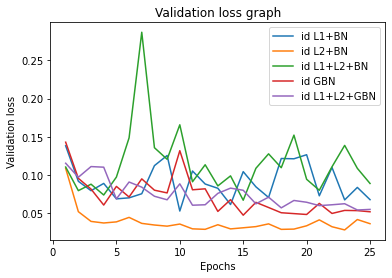

<Figure size 432x288 with 0 Axes>

In [13]:
import matplotlib.pyplot as plt

x = [i for i in range(1,26)]
y = loss_test
Modelgraph = ['L1+BN','L2+BN','L1+L2+BN','GBN','L1+L2+GBN']

plt.title("Validation loss graph")
plt.xlabel("Epochs")
plt.ylabel("Validation loss")


for i in range(len(y)):
    plt.plot(x,y[i],label = 'id %s'%Modelgraph[i])

plt.legend()
plt.show()
plt.savefig('Validation loss graph')

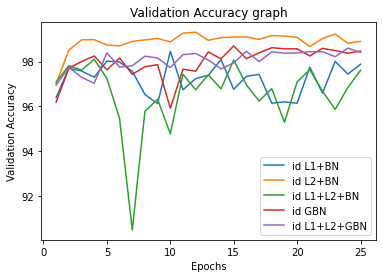

<Figure size 432x288 with 0 Axes>

In [14]:
import matplotlib.pyplot as plt

x = [i for i in range(1,26)]
y = accu
Modelgraph = ['L1+BN','L2+BN','L1+L2+BN','GBN','L1+L2+GBN']

plt.title("Validation Accuracy graph")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")

for i in range(len(y)):
    plt.plot(x,y[i],label = 'id %s'%Modelgraph[i])

plt.legend()
plt.show()
plt.savefig('Validation Accuracy graph_')

In [18]:
# Load
model = torch.load(PATH)
model.eval()

tot = 0
data_ = []
target_ = []
pred_ = []
correct = 0
tot_correct = 0
indx = []

for data, target in test_loader:
  data, target = data.to(device), target.to(device)
  output = model(data)
  pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
  correct += pred.eq(target.view_as(pred)).sum().item()
  equals = pred.eq(target.view_as(pred)).tolist()
    
  for idx in range(0,len(equals)):
    if equals[idx] == [False]:
      indx.append(idx)
      data_.append(data[idx])
      target_.append(target[idx])
      pred_.append(pred[idx])


  if len(indx) > 25:
    break

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:81: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [19]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(15,4), rows=2, interp=False,titles = None):
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        if titles is not None:
            sp.set_title( titles[i].tolist(), fontsize=14)

        sp.axis('Off')
        plt.imshow((torch.squeeze(ims[i]).tolist()))


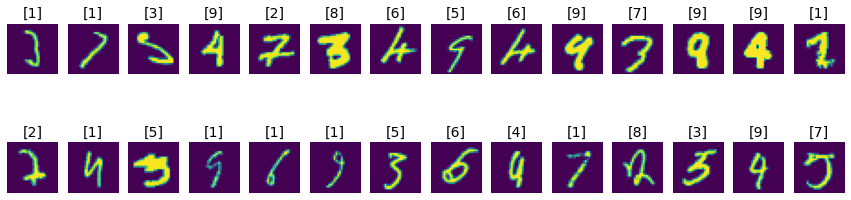

In [20]:
plots(data_,titles = pred_)
